In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Polygon
import geopy.distance
warnings.simplefilter("ignore", UserWarning)

sns.set(font_scale=0.8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/University/GeoAI_LST/2016_LA_merged_scaled_buffer.csv", delimiter=",")
df.head()

,time_index,latitude,longitude,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt,...,SAVI_mean_1000m,SAVI_stdDev_1000m,SWIR1_mean_1000m,SWIR1_stdDev_1000m,SWIR2_mean_1000m,SWIR2_stdDev_1000m,Slope_mean_1000m,Slope_stdDev_1000m,Water_dist_mean_1000m,Water_dist_stdDev_1000m
0,2016-06-22 18:00:00,34.281708,-119.212710,2016-06-22 17:35:25,18.88888,78.0,1.34112,227.0,34.281708_-119.21271,2016-06-22 18:00:00,...,0.280450,0.124373,0.269359,0.050461,0.193750,0.043560,5.012306,4.769188,2223.357490,1427.557953
1,2016-06-22 19:00:00,33.770424,-118.150696,2016-06-22 18:38:53,22.77776,74.0,1.78816,196.0,33.770424_-118.150696,2016-06-22 19:00:00,...,0.135314,0.049228,0.198597,0.032042,0.159531,0.024247,1.838091,1.159238,1206.189289,863.879837
2,2016-06-22 19:00:00,34.171330,-118.042500,2016-06-22 18:43:54,30.55557,43.0,0.00000,40.0,34.17133_-118.0425,2016-06-22 19:00:00,...,0.233804,0.046737,0.196802,0.040870,0.140675,0.038861,14.960462,10.913271,10732.669792,3382.888550
3,2016-06-22 19:00:00,34.042170,-118.521170,2016-06-22 18:42:31,21.11110,81.0,0.89408,253.0,34.04217_-118.52117,2016-06-22 19:00:00,...,0.235600,0.085754,0.191932,0.041900,0.140140,0.038668,5.427906,5.050253,2363.242989,1552.830042
4,2016-06-22 19:00:00,35.058390,-119.084160,2016-06-22 18:30:10,33.33334,21.0,0.00000,0.0,35.05839_-119.08416,2016-06-22 19:00:00,...,0.424338,0.157917,0.269627,0.067562,0.177888,0.074911,2.195274,1.293796,395.385324,436.791924


In [ ]:
# limit to only features used in best performing model
df = df[['longitude', 'latitude', 'temperature', 'LST_mean_30m', 'cos_time', 'sin_time', 'Elevation_mean_30m', 'Red_mean_30m',
 'Elevation_stdDev_30m', 'Blue_mean_30m', 'Water_dist_mean_30m',
 'NDVI_mean_30m', 'MNDWI_stdDev_30m' ,'SWIR1_mean_30m', 'Green_mean_30m',
 'Slope_stdDev_30m', 'NDVI_stdDev_30m', 'Slope_mean_30m' ,'Green_stdDev_30m',
 'SWIR1_stdDev_30m' ,'MNDWI_mean_30m' ,'NDBI_mean_30m',
 'Water_dist_stdDev_30m' ,'NDBI_stdDev_30m', 'EVI_mean_30m', 'EVI_stdDev_30m',
 'NBAI_stdDev_30m' ,'NBAI_mean_30m']]

total # cells: 36
aprox. cell size: 30.37
average #points per cell: 168.83
cells with > 10 points: 31


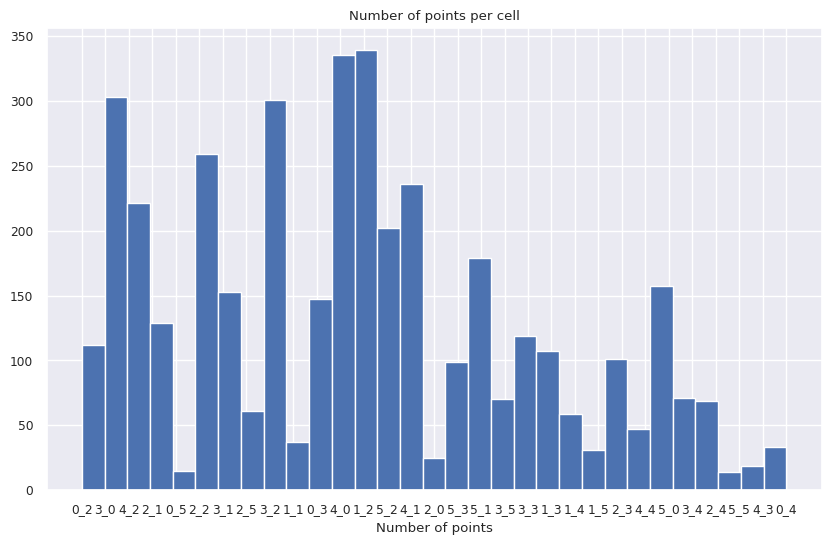

In [ ]:
# create grid
grid_size = 6
min_count = 10

min_lon, min_lat = df[['longitude', 'latitude']].values.min(axis=0)
max_lon, max_lat = df[['longitude', 'latitude']].values.max(axis=0)
lon_step = (max_lon - min_lon) / grid_size
lat_step = (max_lat - min_lat) / grid_size

df['lon_cell'] = ((df['longitude'] - min_lon) / lon_step).astype(int).clip(0, grid_size - 1)
df['lat_cell'] = ((df['latitude'] - min_lat) / lat_step).astype(int).clip(0, grid_size - 1)
df['lonlat_cell'] = df['lon_cell'].astype(str) + '_' + df['lat_cell'].astype(str)
cell_count = df.groupby(['lat_cell', 'lon_cell']).size().unstack()

print("total # cells:", grid_size * grid_size)
print("aprox. cell size:", round((geopy.distance.geodesic((min_lat, min_lon), (min_lat, max_lon)).km / grid_size),2))
print("average #points per cell:", round(np.array(cell_count.dropna()).flatten().mean(), 2))
print(f"cells with > {min_count} points:", len(np.where(np.array(cell_count).flatten() > 10)[0]))

df['lonlat_cell'].hist(figsize=(10, 6), bins=31)
plt.title('Number of points per cell')
plt.xlabel("Number of points")
plt.show()

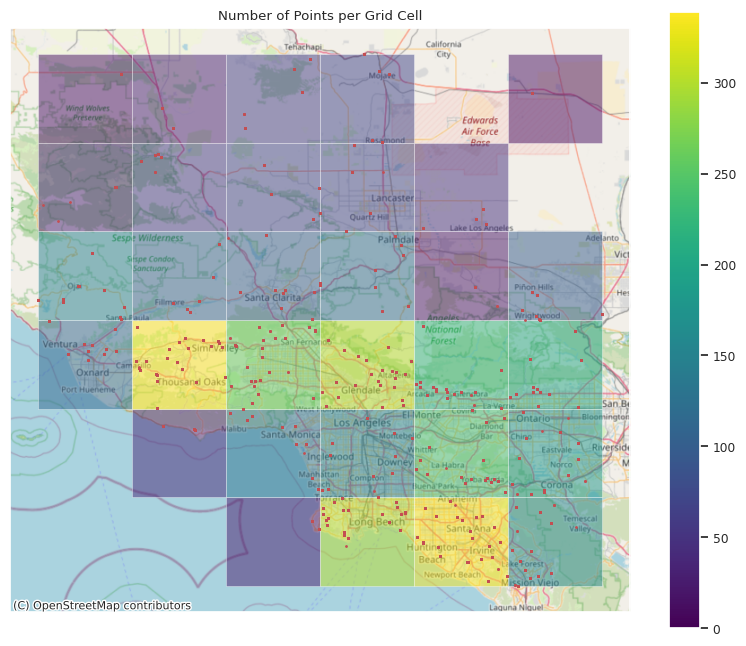

In [ ]:
# plot cells & number of points over map
grid_cells = []
for i in range(grid_size):
    for j in range(grid_size):
        lon1, lat1 = min_lon + i * lon_step, min_lat + j * lat_step
        lon2, lat2 = lon1 + lon_step, lat1 + lat_step
        polygon = Polygon([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)])
        grid_cells.append({'lon_cell': i, 'lat_cell': j, 'geometry': polygon})

grid_gdf = gpd.GeoDataFrame(grid_cells, crs="EPSG:4326")
cell_counts = df.groupby(['lon_cell', 'lat_cell']).size().reset_index(name='count')
grid_gdf = grid_gdf.merge(cell_counts, on=['lon_cell', 'lat_cell'], how='left').fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
grid_gdf.plot(column='count', cmap='viridis', linewidth=0.5, legend=True, ax=ax, alpha=grid_gdf["count"].apply(lambda x: 0 if x == 0 else 0.5))
ctx.add_basemap(ax, crs=grid_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xticks([])
ax.set_yticks([])
ax.plot(df['longitude'], df['latitude'], 'ro', markersize=1, alpha=1)
plt.title("Number of Points per Grid Cell")
plt.show()

In [ ]:
# remove points in cells with < 10 values
df = df[df.groupby('lonlat_cell').lonlat_cell.transform('size') > min_count]

# set apart final validation set/cells
num_avail_cells = len(df['lonlat_cell'].unique())
num_cells_vali = int(num_avail_cells * 0.2)

cells_vali = np.random.choice(df['lonlat_cell'].unique(), num_cells_vali, replace=False)
print(cells_vali)
df_vali = df[df['lonlat_cell'].isin(cells_vali)]
df_cv = df[~df['lonlat_cell'].isin(cells_vali)]

print('points in vali:', df_vali.shape[0])
print('points in cv:', df_cv.shape[0])

['2_4' '5_5' '5_3' '3_0' '3_5' '4_4']
points in vali: 602
points in cv: 3448


In [ ]:
dropcols = ['temperature', 'longitude', 'latitude','lon_cell', 'lat_cell', 'lonlat_cell']
output_df = pd.DataFrame(columns=['Split', 'Number of training cells', 'MAE_avg', 'MAE_std','MSE_avg','MSE_std', 'RMSE_avg', 'RMSE_std','R2_avg','R2_std'])

# define best model
train_splits = np.arange(0.1, 1.0, 0.1)[::-1]
model_xgb = xgb.XGBRegressor(
    subsample=0.75,
    min_child_weight=2,
    max_depth=6,
    gamma=0,
    eta=0.1,
    random_state=42
)

# do 1-fold spatial CV on different splits
for train_split in train_splits:
    cv_mae, cv_mse, cv_rmse, cv_r2 = [], [], [], []
    num_cells_train = int((num_avail_cells-num_cells_vali) * train_split)
    print(num_cells_train)

    for cv in range(10):
        # random cells
        cells_train = np.random.choice(df_cv['lonlat_cell'].unique(), num_cells_train, replace=False)

        # prep data
        df_train = df_cv[df_cv['lonlat_cell'].isin(cells_train)]
        df_test = df_cv[~df_cv['lonlat_cell'].isin(cells_train)]
        X_train = df_train.drop(columns=dropcols)
        y_train = df_train['temperature']
        X_test = df_test.drop(columns=dropcols)
        y_test = df_test['temperature']

        # train & eval model
        model_xgb.fit(X_train, y_train)
        y_pred = model_xgb.predict(X_test)

        cv_mae.append(mean_absolute_error(y_test, y_pred))
        cv_mse.append(mean_squared_error(y_test, y_pred))
        cv_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        cv_r2.append(r2_score(y_test, y_pred))

    # average of CVs
    splitrow = [train_split, num_cells_train]
    for i in [cv_mae, cv_mse, cv_rmse, cv_r2]:
        splitrow.append(np.mean(i))
        splitrow.append(np.std(i))
    print(splitrow)
    output_df.loc[len(output_df)] = splitrow


22
[0.9, 22, 1.7871620941950144, 0.23190680500062144, 5.861171358558167, 1.4886825067400122, 2.4024624763046325, 0.29890702318008455, 0.8287315068574225, 0.031468511993768856]
20
[0.8, 20, 1.8501921159031383, 0.20886507286048647, 6.165799896257227, 1.2901071428074082, 2.471053349295486, 0.24432609601266136, 0.8199319086912272, 0.025834956641378064]
17
[0.7000000000000001, 17, 1.8042783278700423, 0.16295941408704084, 5.851281407566776, 1.1212762040857935, 2.40774863925188, 0.23243901941691886, 0.837256628182242, 0.02416498501570679]
15
[0.6, 15, 1.7466775823255898, 0.09507664099084184, 5.4920093953684015, 0.5757338648626984, 2.34034772163254, 0.12158099036354858, 0.8312692968570159, 0.014097110761759827]
12
[0.5, 12, 1.8419819792518652, 0.06297693132180689, 6.0085977236345425, 0.3865237716262802, 2.4500328106371705, 0.07705160891161274, 0.8199661728497647, 0.013414804224121555]
10
[0.4, 10, 1.9399465182178735, 0.21649753459362858, 6.523233068768865, 1.4128752523348747, 2.542005555886615

In [ ]:
output_df['Split'] = output_df['Split'].round(2)
output_df

,Split,Number of training cells,MAE_avg,MAE_std,MSE_avg,MSE_std,RMSE_avg,RMSE_std,R2_avg,R2_std
0,0.9,22.0,1.787162,0.231907,5.861171,1.488683,2.402462,0.298907,0.828732,0.031469
1,0.8,20.0,1.850192,0.208865,6.165800,1.290107,2.471053,0.244326,0.819932,0.025835
2,0.7,17.0,1.804278,0.162959,5.851281,1.121276,2.407749,0.232439,0.837257,0.024165
3,0.6,15.0,1.746678,0.095077,5.492009,0.575734,2.340348,0.121581,0.831269,0.014097
4,0.5,12.0,1.841982,0.062977,6.008598,0.386524,2.450033,0.077052,0.819966,0.013415
5,0.4,10.0,1.939947,0.216498,6.523233,1.412875,2.542006,0.247873,0.802058,0.046812
6,0.3,7.0,2.012101,0.081726,7.177875,0.615260,2.676716,0.114313,0.789337,0.019176
7,0.2,5.0,2.226431,0.197566,8.532437,1.479048,2.910120,0.252272,0.742799,0.046050
8,0.1,2.0,2.623391,0.381736,11.700190,3.159925,3.391417,0.445512,0.650549,0.095184


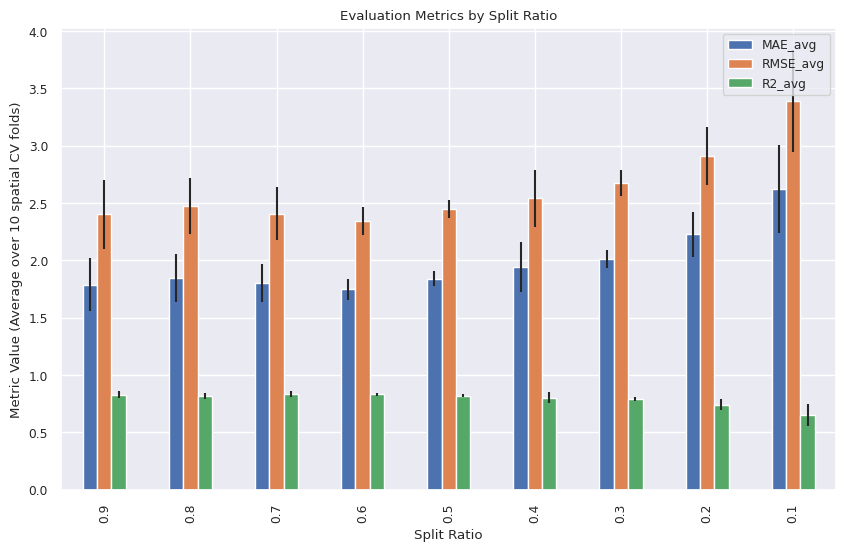

In [ ]:
output_df.plot(kind='bar', x='Split', y=['MAE_avg', 'RMSE_avg', 'R2_avg'], yerr=[output_df['MAE_std'], output_df['RMSE_std'], output_df['R2_std']], figsize=(10, 6))
plt.title('Evaluation Metrics by Split Ratio')
plt.xlabel('Split Ratio')
plt.ylabel('Metric Value (Average over 10 spatial CV folds)')
plt.show()

MAE 1.6705237807238953
MSE 4.697871032700011
RMSE 2.1674572735581226
R2 0.8828853449992702


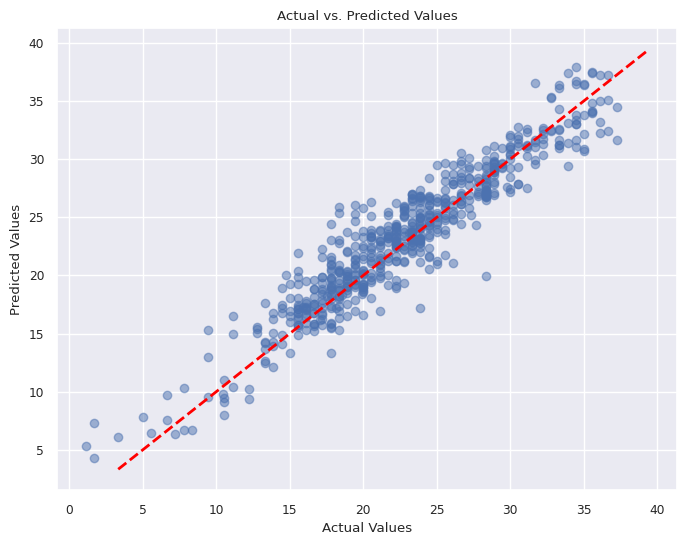

In [ ]:
# check split of 0.6 on validation set
best_train_split = 0.6

num_cells_train = int((num_avail_cells-num_cells_vali) * best_train_split)
cells_train = np.random.choice(df_cv['lonlat_cell'].unique(), num_cells_train, replace=False)

df_train_final = df_cv[df_cv['lonlat_cell'].isin(cells_train)]
X_train_final = df_train_final.drop(columns=dropcols)
y_train_final = df_train_final['temperature']
# validation set
X_vali = df_vali.drop(columns=dropcols)
y_vali = df_vali['temperature']

model_xgb.fit(X_train_final, y_train_final)
y_pred_vali = model_xgb.predict(X_vali)

print('MAE', mean_absolute_error(y_vali, y_pred_vali))
print('MSE', mean_squared_error(y_vali, y_pred_vali))
print('RMSE', np.sqrt(mean_squared_error(y_vali, y_pred_vali)))
print('R2', r2_score(y_vali, y_pred_vali))

# plot simple predicted vs real plot
plt.figure(figsize=(8, 6))
plt.scatter(y_vali, y_pred_vali, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()

In [ ]:
# check whether model can predict the other half, spatially
halves = [df['lon_cell'].astype(int) < 3, df['lon_cell'].astype(int)  >= 3, df['lat_cell'].astype(int)  < 3, df['lat_cell'].astype(int)  >= 3]
halves_str = ['train west, predict east', 'train east, predict west', 'train south, predict north', 'train north, predict south']
output_df_halves = pd.DataFrame(columns=['Half Split', 'Points in training set', 'MAE', 'MSE', 'RMSE', 'R2'])

for i, hcv in enumerate(halves):
    df_train = df[hcv]
    df_test = df[~hcv]
    df_test = df_cv[~df_cv['lonlat_cell'].isin(cells_train)]
    X_train = df_train.drop(columns=dropcols)
    y_train = df_train['temperature']
    X_test = df_test.drop(columns=dropcols)
    y_test = df_test['temperature']

    # train & eval model
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)

    output_df_halves.loc[len(output_df_halves)] = [
        halves_str[i],
        X_train.shape[0],
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        r2_score(y_test, y_pred)
    ]

output_df_halves

,Half Split,Points in training set,MAE,MSE,RMSE,R2
0,"train west, predict east",1524,1.283642,3.144426,1.773253,0.904889
1,"train east, predict west",2526,0.973448,2.528193,1.590029,0.923528
2,"train south, predict north",2988,0.869649,2.105538,1.451047,0.936313
3,"train north, predict south",1062,1.940662,6.707586,2.589901,0.797112
